In [ ]:
!pip install numpy matplotlib seaborn scipy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import cdist
import time

# 3D Flight Dyanmics
class VoxelEnvironment:
    def __init__(self, size=(100, 100, 100), resolution=1.0):
        """
        Discrete abstraction of the continuous 3D flight space.
        size: Dimensions of the world (meters)
        resolution: Size of each voxel (meters)
        """
        self.size = np.array(size)
        self.resolution = resolution
        self.grid_dims = (self.size / resolution).astype(int)
        # Probabilistic Occupancy Grid
        self.grid = np.zeros(self.grid_dims)
        self.obstacles = []

    def add_obstacles(self, num_obstacles=15, radius_range=(5, 10)):
        """Generates random spherical obstacles (static)."""
        for _ in range(num_obstacles):
            center = np.random.rand(3) * self.size
            radius = np.random.uniform(*radius_range)
            self.obstacles.append({'center': center, 'radius': radius})
            # Discretize into voxels for fast lookup
            min_bound = np.maximum(0, (center - radius) / self.resolution).astype(int)
            max_bound = np.minimum(self.grid_dims, (center + radius) / self.resolution).astype(int)

            for i in range(min_bound[0], max_bound[0]):
                for j in range(min_bound[1], max_bound[1]):
                    for k in range(min_bound[2], max_bound[2]):
                        voxel_center = np.array([i, j, k]) * self.resolution
                        if np.linalg.norm(voxel_center - center) <= radius:
                            self.grid[i, j, k] = 1.0

    def check_occupancy(self, positions):
        """
        Returns occupancy probability for a batch of positions.
        """
        indices = (positions / self.resolution).astype(int)
        # Clip to valid range
        indices = np.clip(indices, 0, self.grid_dims - 1)
        return self.grid[indices[:, 0], indices[:, 1], indices[:, 2]]

# Formalization OF NUCA Dynamics
class NUCASwarm:
    def __init__(self, n_drones, environment):
        self.n_drones = n_drones
        self.env = environment

        # State Vectors: Position (x), Velocity (v)
        # Initialize in a cluster
        self.positions = np.random.rand(n_drones, 3) * 20 + [10, 10, 10]
        self.velocities = (np.random.rand(n_drones, 3) - 0.5) * 2
        # Internal State
        self.modes = np.zeros(n_drones)
        self.energy_log = []
         # Logs barrier function values
        self.safety_log = []

        # Hyperparameters
        self.perception_radius = 15.0
        self.comm_radius = 20.0
        self.max_speed = 2.0
        # Hard safety constraint
        self.safe_distance = 3.0

    def compute_local_interactions(self):
        """
        Computes the 'Neighbourhood Interactions' defined in Point 1.
        Returns matrices for separation, alignment, and cohesion vectors.
        """
        dist_matrix = cdist(self.positions, self.positions)

        # Adjacency matrix for communication (Consensus Layer)
        comm_mask = (dist_matrix < self.comm_radius) & (dist_matrix > 0)

        #Alignment
        avg_vel = np.zeros_like(self.velocities)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                avg_vel[i] = np.mean(self.velocities[neighbors], axis=0)

        # Cohesion
        cohesion = np.zeros_like(self.positions)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                center_mass = np.mean(self.positions[neighbors], axis=0)
                cohesion[i] = center_mass - self.positions[i]

        #Avoid intra-swarm collisions
        separation = np.zeros_like(self.positions)
        sep_mask = (dist_matrix < self.safe_distance * 1.5) & (dist_matrix > 0)
        for i in range(self.n_drones):
            too_close = sep_mask[i]
            if np.any(too_close):
                # Vector pointing AWAY from neighbors
                diffs = self.positions[i] - self.positions[too_close]
                # Weight by 1/distance (Repulsive potential)
                dists = dist_matrix[i, too_close][:, None]
                separation[i] = np.sum(diffs / (dists**2 + 1e-5), axis=0)

        return avg_vel, cohesion, separation

    def get_obstacle_forces(self):
        """
        Calculates repulsion from the Voxel Environment.
        """
        forces = np.zeros_like(self.positions)
        for i, pos in enumerate(self.positions):
            for obs in self.env.obstacles:
                dist = np.linalg.norm(pos - obs['center'])
                 # Interaction range
                if dist < obs['radius'] + 5.0:
                    # Gradient of the repulsion potential field
                    direction = pos - obs['center']
                    norm_dir = direction / (np.linalg.norm(direction) + 1e-6)
                    forces[i] += norm_dir * (1.0 / (dist - obs['radius'] + 0.1))
        return forces

    # Meta-Rules And Adaptive Strategies
    def update_meta_rules(self, obs_forces):
        """
        Dynamically switches strategies based on environmental entropy/threat.
        Formalism: Mode_t+1 = argmax_mode U(State, Environment)
        """
        force_mags = np.linalg.norm(obs_forces, axis=1)
        # Adaptive Switching Logic
        threat_threshold = 0.5
        self.modes = np.where(force_mags > threat_threshold, 1, 0)

        return self.modes

    # Safety And Formal Verifiaction
    def check_barrier_certificates(self):
        """
        Calculates the Control Barrier Function (CBF) h(x).
        Safety requires h(x) >= 0 for all time t.
        h(x) = distance_to_obstacle - safe_radius
        """
        min_barrier_val = float('inf')

        # Check against obstacles
        for pos in self.positions:
            for obs in self.env.obstacles:
                # Barrier function h(x)
                h_x = np.linalg.norm(pos - obs['center']) - obs['radius']
                if h_x < min_barrier_val:
                    min_barrier_val = h_x

        # Check against other drones
        dist_matrix = cdist(self.positions, self.positions) + np.eye(self.n_drones) * 100
        min_inter_dist = np.min(dist_matrix) / 2.0
        final_h = min(min_barrier_val, min_inter_dist)
        self.safety_log.append(final_h)
        return final_h

    # Update Loop
    def step(self, dt=0.1, target=np.array([80, 80, 80])):
        # Sensing & Communication
        align, cohere, separate = self.compute_local_interactions()
        obs_repulsion = self.get_obstacle_forces()

        #Adaptation (Meta-Rules)
        self.update_meta_rules(obs_repulsion)

        # Apply Forces based on Mode (NUCA Rule Formalism)
        # Coefficients for Mode 0 (Cruise)
        w_align_0, w_cohere_0, w_sep_0, w_obs_0, w_targ_0 = 0.5, 0.2, 0.8, 1.0, 0.5
        # Coefficients for Mode 1 Prioritize repulsion
        w_align_1, w_cohere_1, w_sep_1, w_obs_1, w_targ_1 = 0.1, 0.0, 2.0, 5.0, 0.1
        # Vectorized weight application
        w_align = np.where(self.modes[:,None]==1, w_align_1, w_align_0)
        w_cohere = np.where(self.modes[:,None]==1, w_cohere_1, w_cohere_0)
        w_sep   = np.where(self.modes[:,None]==1, w_sep_1, w_sep_0)
        w_obs   = np.where(self.modes[:,None]==1, w_obs_1, w_obs_0)
        w_targ  = np.where(self.modes[:,None]==1, w_targ_1, w_targ_0)

        target_vec = target - self.positions
        target_vec = target_vec / (np.linalg.norm(target_vec, axis=1, keepdims=True) + 1e-6)

        acceleration = (align * w_align +
                        cohere * w_cohere +
                        separate * w_sep +
                        obs_repulsion * w_obs +
                        target_vec * w_targ)

        # 4. Integration
        self.velocities += acceleration * dt

        # Clamp velocity (Physical constraint)
        speed = np.linalg.norm(self.velocities, axis=1, keepdims=True)
        self.velocities = np.where(speed > self.max_speed,
                                   self.velocities / speed * self.max_speed,
                                   self.velocities)

        self.positions += self.velocities * dt

        # Efficiency Logging (Energy ~ v^2)
        instant_energy = np.sum(speed**2)
        self.energy_log.append(instant_energy)

        #Safety Check
        self.check_barrier_certificates()

In [ ]:
# Execution And Visualization
env = VoxelEnvironment(size=(100, 100, 100))
env.add_obstacles(num_obstacles=8, radius_range=(8, 15))
swarm = NUCASwarm(n_drones=20, environment=env)
# Simulation
steps = 300
trajectory_history = np.zeros((steps, swarm.n_drones, 3))
print("Starting NUCA Swarm Simulation...")
for t in range(steps):
    swarm.step(dt=0.2, target=np.array([90, 90, 90]))
    trajectory_history[t] = swarm.positions

Starting NUCA Swarm Simulation...


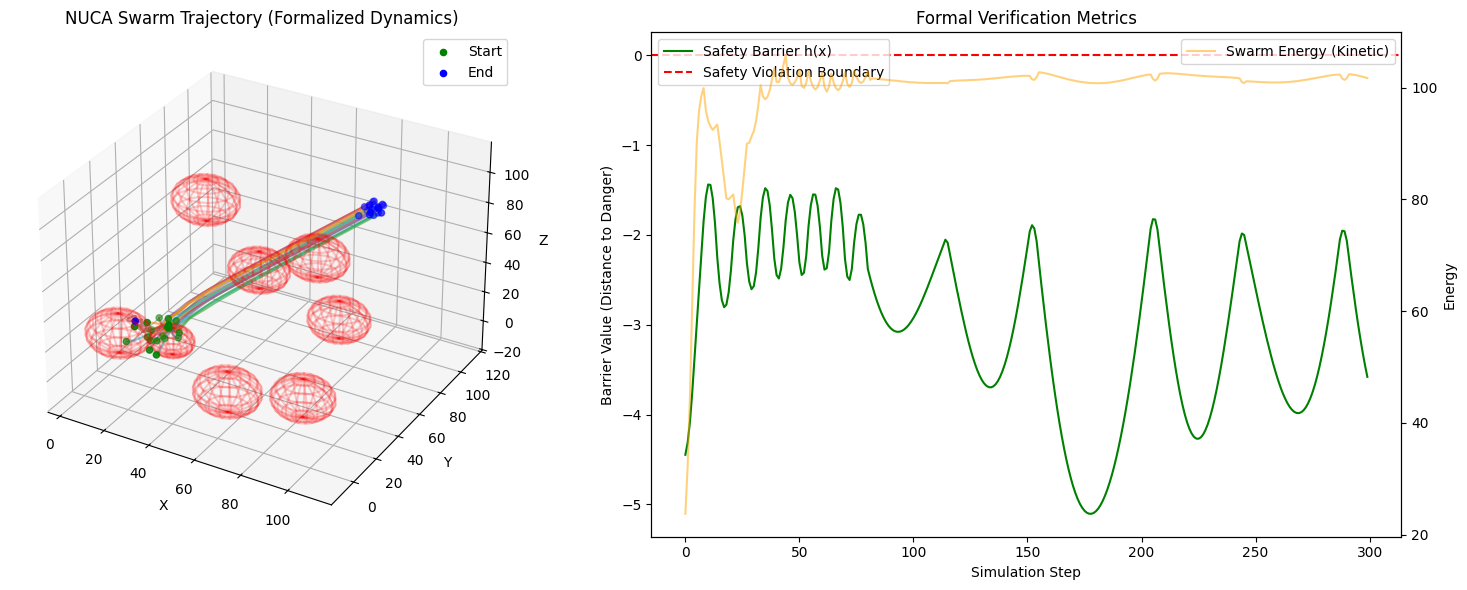

In [ ]:
# Visualization Results
fig = plt.figure(figsize=(16, 6))

# 3D Trajectory
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("NUCA Swarm Trajectory (Formalized Dynamics)")

# Plot Obstacles
for obs in env.obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['center'][0] + obs['radius'] * np.cos(u) * np.sin(v)
    y = obs['center'][1] + obs['radius'] * np.sin(u) * np.sin(v)
    z = obs['center'][2] + obs['radius'] * np.cos(v)
    ax1.plot_wireframe(x, y, z, color='r', alpha=0.2)

# Plot Drone Paths
for i in range(swarm.n_drones):
    ax1.plot(trajectory_history[:, i, 0],
             trajectory_history[:, i, 1],
             trajectory_history[:, i, 2], alpha=0.6)

# Start and End points
ax1.scatter(trajectory_history[0, :, 0], trajectory_history[0, :, 1], trajectory_history[0, :, 2], c='g', s=20, label='Start')
ax1.scatter(trajectory_history[-1, :, 0], trajectory_history[-1, :, 1], trajectory_history[-1, :, 2], c='b', s=20, label='End')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Formal Verification Metrics (Safety & Efficiency)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Formal Verification Metrics")
time_axis = np.arange(steps)

# Plot Safety (Barrier Function h(x))
ax2.plot(time_axis, swarm.safety_log, color='green', label='Safety Barrier h(x)')
ax2.axhline(0, color='red', linestyle='--', label='Safety Violation Boundary')

# Plot Energy (Efficiency) on twin axis
ax3 = ax2.twinx()
ax3.plot(time_axis, swarm.energy_log, color='orange', alpha=0.5, label='Swarm Energy (Kinetic)')
ax3.set_ylabel('Energy')

ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Barrier Value (Distance to Danger)')
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import cdist
import time

# 3D Flight Dynamics
class VoxelEnvironment:
    def __init__(self, size=(100, 100, 100), resolution=1.0):
        """
        Discrete abstraction of the continuous 3D flight space.
        size: Dimensions of the world (meters)
        resolution: Size of each voxel (meters)
        """
        self.size = np.array(size)
        self.resolution = resolution
        self.grid_dims = (self.size / resolution).astype(int)

        # Probabilistic Occupancy Grid
        self.grid = np.zeros(self.grid_dims)
        self.obstacles = []

    def add_obstacles(self, num_obstacles=15, radius_range=(5, 10)):
        """Generates random spherical obstacles (static)."""
        for _ in range(num_obstacles):
            center = np.random.rand(3) * self.size
            radius = np.random.uniform(*radius_range)
            self.obstacles.append({'center': center, 'radius': radius})

            # Discretize into voxels for fast lookup
            min_bound = np.maximum(0, (center - radius) / self.resolution).astype(int)
            max_bound = np.minimum(self.grid_dims, (center + radius) / self.resolution).astype(int)

            for i in range(min_bound[0], max_bound[0]):
                for j in range(min_bound[1], max_bound[1]):
                    for k in range(min_bound[2], max_bound[2]):
                        voxel_center = np.array([i, j, k]) * self.resolution
                        if np.linalg.norm(voxel_center - center) <= radius:
                            self.grid[i, j, k] = 1.0

    def check_occupancy(self, positions):
        """
        Returns occupancy probability for a batch of positions.
        """
        indices = (positions / self.resolution).astype(int)
        # Clip to valid range
        indices = np.clip(indices, 0, self.grid_dims - 1)
        return self.grid[indices[:, 0], indices[:, 1], indices[:, 2]]

# Formalizaton Of NUCA Dynamics
class NUCASwarm:
    def __init__(self, n_drones, environment):
        self.n_drones = n_drones
        self.env = environment
        self.positions = np.random.rand(n_drones, 3) * 20 + [10, 10, 10]
        self.velocities = (np.random.rand(n_drones, 3) - 0.5) * 2
        # Internal State
        self.modes = np.zeros(n_drones)
        self.energy_log = []
        self.safety_log = []
        # Hyperparameters
        self.perception_radius = 15.0
        self.comm_radius = 20.0
        self.max_speed = 2.0
        self.safe_distance = 3.0

    def compute_local_interactions(self):
        """
        Computes the 'Neighbourhood Interactions' defined in Point 1.
        Returns matrices for separation, alignment, and cohesion vectors.
        """
        dist_matrix = cdist(self.positions, self.positions)
        # Adjacency matrix for communication
        comm_mask = (dist_matrix < self.comm_radius) & (dist_matrix > 0)
        #Alignment
        avg_vel = np.zeros_like(self.velocities)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                avg_vel[i] = np.mean(self.velocities[neighbors], axis=0)
        # Cohesion
        cohesion = np.zeros_like(self.positions)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                center_mass = np.mean(self.positions[neighbors], axis=0)
                cohesion[i] = center_mass - self.positions[i]
        #Separation
        separation = np.zeros_like(self.positions)
        sep_mask = (dist_matrix < self.safe_distance * 1.5) & (dist_matrix > 0)
        for i in range(self.n_drones):
            too_close = sep_mask[i]
            if np.any(too_close):
                diffs = self.positions[i] - self.positions[too_close]
                dists = dist_matrix[i, too_close][:, None]
                separation[i] = np.sum(diffs / (dists**2 + 1e-5), axis=0)

        return avg_vel, cohesion, separation

    def get_obstacle_forces(self):
        """
        Calculates repulsion from the Voxel Environment.
        """
        forces = np.zeros_like(self.positions)
        for i, pos in enumerate(self.positions):
            for obs in self.env.obstacles:
                dist = np.linalg.norm(pos - obs['center'])
                if dist < obs['radius'] + 5.0:
                    direction = pos - obs['center']
                    norm_dir = direction / (np.linalg.norm(direction) + 1e-6)
                    forces[i] += norm_dir * (1.0 / (dist - obs['radius'] + 0.1))
        return forces

    # Meta-Rules And Adaptive Strategies
    def update_meta_rules(self, obs_forces):
        """
        Dynamically switches strategies based on environmental entropy/threat.
        Formalism: Mode_t+1 = argmax_mode U(State, Environment)
        """
        force_mags = np.linalg.norm(obs_forces, axis=1)

        # Adaptive Switching Logic
        threat_threshold = 0.5
        self.modes = np.where(force_mags > threat_threshold, 1, 0)

        return self.modes

    # Safety And Formal Verification
    def check_barrier_certificates(self):
        """
        Calculates the Control Barrier Function (CBF) h(x).
        Safety requires h(x) >= 0 for all time t.
        h(x) = distance_to_obstacle - safe_radius
        """
        min_barrier_val = float('inf')

        # Check against obstacles
        for pos in self.positions:
            for obs in self.env.obstacles:
                # Barrier function h(x)
                h_x = np.linalg.norm(pos - obs['center']) - obs['radius']
                if h_x < min_barrier_val:
                    min_barrier_val = h_x

        # Check against other drones
        dist_matrix = cdist(self.positions, self.positions) + np.eye(self.n_drones) * 100
        min_inter_dist = np.min(dist_matrix) / 2.0

        final_h = min(min_barrier_val, min_inter_dist)
        self.safety_log.append(final_h)
        return final_h

    #Active Safety Filter (QP-based CBF)
    def apply_cbf_filter(self, nominal_velocity, dt):
        """
        Modifies the NUCA-proposed velocity to rigorously enforce safety.
        Solves a localized optimization (QP) to find the closest safe velocity.
        """
        safe_velocity = nominal_velocity.copy()
        gamma = 10.0

        # Iterate through all agents
        for i in range(self.n_drones):
            # Check obstacles
            for obs in self.env.obstacles:
                pos = self.positions[i]
                # Barrier Function
                h = np.linalg.norm(pos - obs['center']) - obs['radius'] - 2.0
                diff = pos - obs['center']
                dh_dx = diff / (np.linalg.norm(diff) + 1e-6)
                # Lie Derivative
                L_f_h = np.dot(dh_dx, nominal_velocity[i])
                # Safety Constraint
                if L_f_h + gamma * h < 0:
                    violation = -(L_f_h + gamma * h)
                    safe_velocity[i] += violation * dh_dx

        return safe_velocity


    # Update Loop
    def step(self, dt=0.1, target=np.array([80, 80, 80])):
        #Sensing & Communication
        align, cohere, separate = self.compute_local_interactions()
        obs_repulsion = self.get_obstacle_forces()
        #Adaptation (Meta-Rules)
        self.update_meta_rules(obs_repulsion)
        # Coefficients for Mode 0 (Cruise)
        w_align_0, w_cohere_0, w_sep_0, w_obs_0, w_targ_0 = 0.5, 0.2, 0.8, 1.0, 0.5
        # Coefficients for Mode 1 *Prioritize repulsion)
        w_align_1, w_cohere_1, w_sep_1, w_obs_1, w_targ_1 = 0.1, 0.0, 2.0, 5.0, 0.1
        # Vectorized weight application
        w_align = np.where(self.modes[:,None]==1, w_align_1, w_align_0)
        w_cohere = np.where(self.modes[:,None]==1, w_cohere_1, w_cohere_0)
        w_sep   = np.where(self.modes[:,None]==1, w_sep_1, w_sep_0)
        w_obs   = np.where(self.modes[:,None]==1, w_obs_1, w_obs_0)
        w_targ  = np.where(self.modes[:,None]==1, w_targ_1, w_targ_0)
        target_vec = target - self.positions
        target_vec = target_vec / (np.linalg.norm(target_vec, axis=1, keepdims=True) + 1e-6)
        acceleration = (align * w_align +
                        cohere * w_cohere +
                        separate * w_sep +
                        obs_repulsion * w_obs +
                        target_vec * w_targ)

        # Integration
        proposed_velocity = self.velocities + acceleration * dt
        # Clamp velocity (Physical constraint before filter)
        speed = np.linalg.norm(proposed_velocity, axis=1, keepdims=True)
        proposed_velocity = np.where(speed > self.max_speed,
                                   proposed_velocity / speed * self.max_speed,
                                   proposed_velocity)

        #Apply Active Safety Filter
        final_velocity = self.apply_cbf_filter(proposed_velocity, dt)
        # Update state
        self.velocities = final_velocity
        self.positions += self.velocities * dt
        #Efficiency Logging
        instant_energy = np.sum(speed**2)
        self.energy_log.append(instant_energy)
        #Safety Check
        self.check_barrier_certificates()

In [ ]:
# Execution And Visualization
env = VoxelEnvironment(size=(100, 100, 100))
env.add_obstacles(num_obstacles=8, radius_range=(8, 15))
swarm = NUCASwarm(n_drones=20, environment=env)
# Simulation
steps = 300
trajectory_history = np.zeros((steps, swarm.n_drones, 3))
print("Starting NUCA Swarm Simulation...")
for t in range(steps):
    swarm.step(dt=0.2, target=np.array([90, 90, 90]))
    trajectory_history[t] = swarm.positions

Starting NUCA Swarm Simulation...


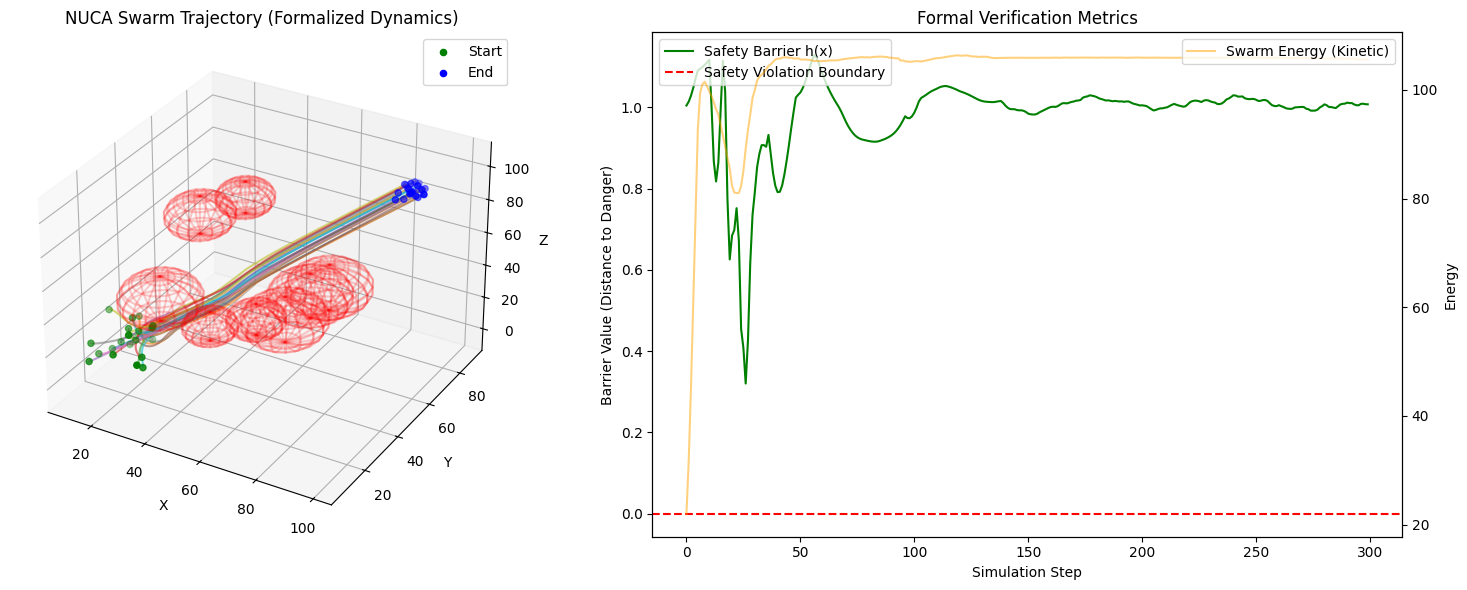

In [ ]:
# Visualization Results
fig = plt.figure(figsize=(16, 6))

# 3D Trajectory
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("NUCA Swarm Trajectory (Formalized Dynamics)")

# Plot Obstacles
for obs in env.obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['center'][0] + obs['radius'] * np.cos(u) * np.sin(v)
    y = obs['center'][1] + obs['radius'] * np.sin(u) * np.sin(v)
    z = obs['center'][2] + obs['radius'] * np.cos(v)
    ax1.plot_wireframe(x, y, z, color='r', alpha=0.2)

# Plot Drone Paths
for i in range(swarm.n_drones):
    ax1.plot(trajectory_history[:, i, 0],
             trajectory_history[:, i, 1],
             trajectory_history[:, i, 2], alpha=0.6)

# Start and End points
ax1.scatter(trajectory_history[0, :, 0], trajectory_history[0, :, 1], trajectory_history[0, :, 2], c='g', s=20, label='Start')
ax1.scatter(trajectory_history[-1, :, 0], trajectory_history[-1, :, 1], trajectory_history[-1, :, 2], c='b', s=20, label='End')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Formal Verification Metrics (Safety & Efficiency)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Formal Verification Metrics")
time_axis = np.arange(steps)

# Plot Safety (Barrier Function h(x))
ax2.plot(time_axis, swarm.safety_log, color='green', label='Safety Barrier h(x)')
ax2.axhline(0, color='red', linestyle='--', label='Safety Violation Boundary')

# Plot Energy (Efficiency) on twin axis
ax3 = ax2.twinx()
ax3.plot(time_axis, swarm.energy_log, color='orange', alpha=0.5, label='Swarm Energy (Kinetic)')
ax3.set_ylabel('Energy')

ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Barrier Value (Distance to Danger)')
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Model-Based Extrapolation for Temporal Alignment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import cdist
import time

# 3D FLIGHT DYNAMICS
class VoxelEnvironment:
    def __init__(self, size=(100, 100, 100), resolution=1.0):
        """
        Discrete abstraction of the continuous 3D flight space.
        size: Dimensions of the world (meters)
        resolution: Size of each voxel (meters)
        """
        self.size = np.array(size)
        self.resolution = resolution
        self.grid_dims = (self.size / resolution).astype(int)
        # Probabilistic Occupancy Grid
        self.grid = np.zeros(self.grid_dims)
        self.obstacles = []

    def add_obstacles(self, num_obstacles=15, radius_range=(5, 10)):
        """Generates random spherical obstacles (static)."""
        for _ in range(num_obstacles):
            center = np.random.rand(3) * self.size
            radius = np.random.uniform(*radius_range)
            self.obstacles.append({'center': center, 'radius': radius})

            # Discretize into voxels for fast lookup
            min_bound = np.maximum(0, (center - radius) / self.resolution).astype(int)
            max_bound = np.minimum(self.grid_dims, (center + radius) / self.resolution).astype(int)

            for i in range(min_bound[0], max_bound[0]):
                for j in range(min_bound[1], max_bound[1]):
                    for k in range(min_bound[2], max_bound[2]):
                        voxel_center = np.array([i, j, k]) * self.resolution
                        if np.linalg.norm(voxel_center - center) <= radius:
                            self.grid[i, j, k] = 1.0

    def check_occupancy(self, positions):
        """Returns occupancy probability for a batch of positions."""
        indices = (positions / self.resolution).astype(int)
        indices = np.clip(indices, 0, self.grid_dims - 1)
        return self.grid[indices[:, 0], indices[:, 1], indices[:, 2]]

# Sesnor Fusion & Temporal Alignment
class SensorFusionUnit:
    def __init__(self):
        self.last_lidar_time = 0
        self.last_cam_time = 0
        self.lidar_buffer = np.zeros(3)
        self.cam_buffer = np.zeros(3)

    def temporal_align(self, current_time, raw_lidar, raw_cam, velocity_estimate):
        """
        Aligns asynchronous sensor data to the current simulation time step.
        Input: Raw sensor positions (mocked here) and current velocity.
        Output: The Fused Position Estimate aligned to 'current_time'.
        """
        #Simulate Asynchronous Arrival
        if current_time - self.last_lidar_time >= 0.1:
             self.lidar_buffer = raw_lidar
             self.last_lidar_time = current_time

        if current_time - self.last_cam_time >= 0.033:
             self.cam_buffer = raw_cam
             self.last_cam_time = current_time

        #Predict forward to align timestamps
        dt_lidar = current_time - self.last_lidar_time
        aligned_lidar = self.lidar_buffer + (velocity_estimate * dt_lidar)
        fused_position = (0.7 * aligned_lidar) + (0.3 * self.cam_buffer)

        return fused_position

# 3. NUCA Swarm Logic
class NUCASwarm:
    def __init__(self, n_drones, environment):
        self.n_drones = n_drones
        self.env = environment
        self.positions = np.random.rand(n_drones, 3) * 20 + [10, 10, 10]
        self.velocities = (np.random.rand(n_drones, 3) - 0.5) * 2

        #Initialize Sensor Fusion Units
        self.sensors = [SensorFusionUnit() for _ in range(n_drones)]
        self.sim_time = 0.0

        # Internal State
        self.modes = np.zeros(n_drones)
        self.energy_log = []
        self.safety_log = []

        # Hyperparameters
        self.perception_radius = 15.0
        self.comm_radius = 20.0
        self.max_speed = 2.0
        self.safe_distance = 3.0

    def compute_local_interactions(self):
        """Computes Separation, Alignment, Cohesion."""
        dist_matrix = cdist(self.positions, self.positions)
        comm_mask = (dist_matrix < self.comm_radius) & (dist_matrix > 0)

        # Alignment
        avg_vel = np.zeros_like(self.velocities)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                avg_vel[i] = np.mean(self.velocities[neighbors], axis=0)

        # Cohesion
        cohesion = np.zeros_like(self.positions)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                center_mass = np.mean(self.positions[neighbors], axis=0)
                cohesion[i] = center_mass - self.positions[i]

        # Separation
        separation = np.zeros_like(self.positions)
        sep_mask = (dist_matrix < self.safe_distance * 1.5) & (dist_matrix > 0)
        for i in range(self.n_drones):
            too_close = sep_mask[i]
            if np.any(too_close):
                diffs = self.positions[i] - self.positions[too_close]
                dists = dist_matrix[i, too_close][:, None]
                separation[i] = np.sum(diffs / (dists**2 + 1e-5), axis=0)

        return avg_vel, cohesion, separation

    def get_obstacle_forces(self):
        """Calculates repulsion from Environment."""
        forces = np.zeros_like(self.positions)
        for i, pos in enumerate(self.positions):
            for obs in self.env.obstacles:
                dist = np.linalg.norm(pos - obs['center'])
                if dist < obs['radius'] + 5.0:
                    direction = pos - obs['center']
                    norm_dir = direction / (np.linalg.norm(direction) + 1e-6)
                    forces[i] += norm_dir * (1.0 / (dist - obs['radius'] + 0.1))
        return forces

    # Meta-Rules And Adaptive Strategies
    def update_meta_rules(self, obs_forces):
        """Dynamically switches strategies based on threat level."""
        force_mags = np.linalg.norm(obs_forces, axis=1)
        threat_threshold = 0.5
        self.modes = np.where(force_mags > threat_threshold, 1, 0)
        return self.modes

    # Safety And Formal Verification
    def check_barrier_certificates(self):
        """Calculates Control Barrier Function (CBF) h(x)."""
        min_barrier_val = float('inf')

        # Check against obstacles
        for pos in self.positions:
            for obs in self.env.obstacles:
                h_x = np.linalg.norm(pos - obs['center']) - obs['radius']
                if h_x < min_barrier_val:
                    min_barrier_val = h_x

        # Check against other drones
        dist_matrix = cdist(self.positions, self.positions) + np.eye(self.n_drones) * 100
        min_inter_dist = np.min(dist_matrix) / 2.0

        final_h = min(min_barrier_val, min_inter_dist)
        self.safety_log.append(final_h)
        return final_h

    # Active Safety Filter (QP-based CBF)
    def apply_cbf_filter(self, nominal_velocity, dt):
        """Modifies velocity to rigorously enforce safety."""
        safe_velocity = nominal_velocity.copy()
        gamma = 10.0

        for i in range(self.n_drones):
            for obs in self.env.obstacles:
                pos = self.positions[i]
                h = np.linalg.norm(pos - obs['center']) - obs['radius'] - 2.0
                diff = pos - obs['center']
                dh_dx = diff / (np.linalg.norm(diff) + 1e-6)
                L_f_h = np.dot(dh_dx, nominal_velocity[i])

                if L_f_h + gamma * h < 0:
                    violation = -(L_f_h + gamma * h)
                    safe_velocity[i] += violation * dh_dx

        return safe_velocity

    # Update Loop
    def step(self, dt=0.1, target=np.array([80, 80, 80])):
        # Update Global Simulation Time
        self.sim_time += dt

        # SENSOR FUSION (Temporal Alignment)
        current_sensed_positions = np.zeros_like(self.positions)

        for i in range(self.n_drones):
            raw_lidar_data = self.positions[i]
            raw_cam_data = self.positions[i]
            aligned_pos = self.sensors[i].temporal_align(
                self.sim_time, raw_lidar_data, raw_cam_data, self.velocities[i]
            )
            current_sensed_positions[i] = aligned_pos



        # Sensing & Communication
        align, cohere, separate = self.compute_local_interactions()
        obs_repulsion = self.get_obstacle_forces()

        # Adaptation (Meta-Rules)
        self.update_meta_rules(obs_repulsion)

        # Coefficients
        w_align_0, w_cohere_0, w_sep_0, w_obs_0, w_targ_0 = 0.5, 0.2, 0.8, 1.0, 0.5
        w_align_1, w_cohere_1, w_sep_1, w_obs_1, w_targ_1 = 0.1, 0.0, 2.0, 5.0, 0.1

        # Vectorized weight application
        w_align = np.where(self.modes[:,None]==1, w_align_1, w_align_0)
        w_cohere = np.where(self.modes[:,None]==1, w_cohere_1, w_cohere_0)
        w_sep   = np.where(self.modes[:,None]==1, w_sep_1, w_sep_0)
        w_obs   = np.where(self.modes[:,None]==1, w_obs_1, w_obs_0)
        w_targ  = np.where(self.modes[:,None]==1, w_targ_1, w_targ_0)

        target_vec = target - self.positions
        target_vec = target_vec / (np.linalg.norm(target_vec, axis=1, keepdims=True) + 1e-6)

        acceleration = (align * w_align +
                        cohere * w_cohere +
                        separate * w_sep +
                        obs_repulsion * w_obs +
                        target_vec * w_targ)

        #Integration
        proposed_velocity = self.velocities + acceleration * dt

        # Clamp velocity
        speed = np.linalg.norm(proposed_velocity, axis=1, keepdims=True)
        proposed_velocity = np.where(speed > self.max_speed,
                                   proposed_velocity / speed * self.max_speed,
                                   proposed_velocity)

        #Apply Active Safety Filter
        final_velocity = self.apply_cbf_filter(proposed_velocity, dt)

        # Update state
        self.velocities = final_velocity
        self.positions += self.velocities * dt

        #Efficiency Logging
        instant_energy = np.sum(speed**2)
        self.energy_log.append(instant_energy)

        #Safety Check
        self.check_barrier_certificates()

In [ ]:
env = VoxelEnvironment(size=(100, 100, 100))
env.add_obstacles(num_obstacles=8, radius_range=(8, 15))
swarm = NUCASwarm(n_drones=20, environment=env)
# Simulation
steps = 300
trajectory_history = np.zeros((steps, swarm.n_drones, 3))
print("Starting NUCA Swarm Simulation with Sensor Fusion...")
for t in range(steps):
    swarm.step(dt=0.2, target=np.array([90, 90, 90]))
    trajectory_history[t] = swarm.positions

Starting NUCA Swarm Simulation with Sensor Fusion...


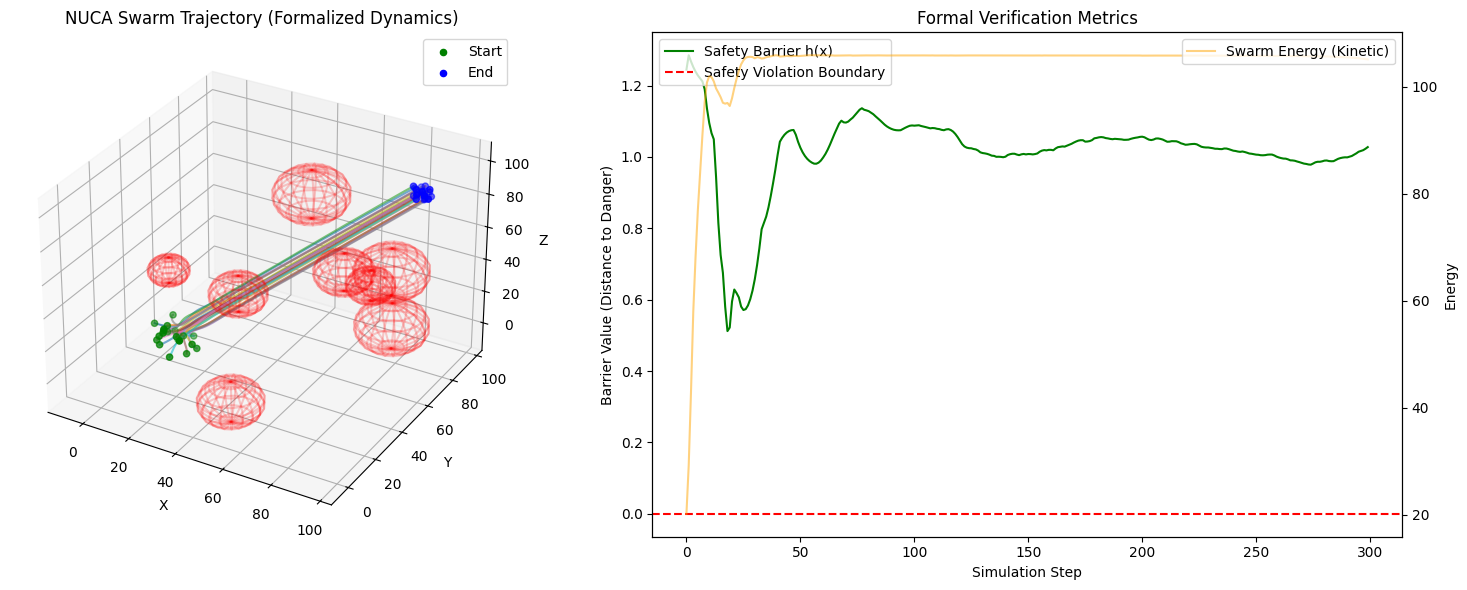

In [ ]:
# Visualization Results
fig = plt.figure(figsize=(16, 6))

# Subplot 1: 3D Trajectory
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("NUCA Swarm Trajectory (Formalized Dynamics)")

# Plot Obstacles
for obs in env.obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['center'][0] + obs['radius'] * np.cos(u) * np.sin(v)
    y = obs['center'][1] + obs['radius'] * np.sin(u) * np.sin(v)
    z = obs['center'][2] + obs['radius'] * np.cos(v)
    ax1.plot_wireframe(x, y, z, color='r', alpha=0.2)

# Plot Drone Paths
for i in range(swarm.n_drones):
    ax1.plot(trajectory_history[:, i, 0],
             trajectory_history[:, i, 1],
             trajectory_history[:, i, 2], alpha=0.6)

# Start and End points
ax1.scatter(trajectory_history[0, :, 0], trajectory_history[0, :, 1], trajectory_history[0, :, 2], c='g', s=20, label='Start')
ax1.scatter(trajectory_history[-1, :, 0], trajectory_history[-1, :, 1], trajectory_history[-1, :, 2], c='b', s=20, label='End')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Formal Verification Metrics (Safety & Efficiency)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Formal Verification Metrics")
time_axis = np.arange(steps)

# Plot Safety (Barrier Function h(x))
ax2.plot(time_axis, swarm.safety_log, color='green', label='Safety Barrier h(x)')
ax2.axhline(0, color='red', linestyle='--', label='Safety Violation Boundary')

# Plot Energy (Efficiency) on twin axis
ax3 = ax2.twinx()
ax3.plot(time_axis, swarm.energy_log, color='orange', alpha=0.5, label='Swarm Energy (Kinetic)')
ax3.set_ylabel('Energy')

ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Barrier Value (Distance to Danger)')
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


Starting NUCA Swarm Simulation with Sensor Fusion...


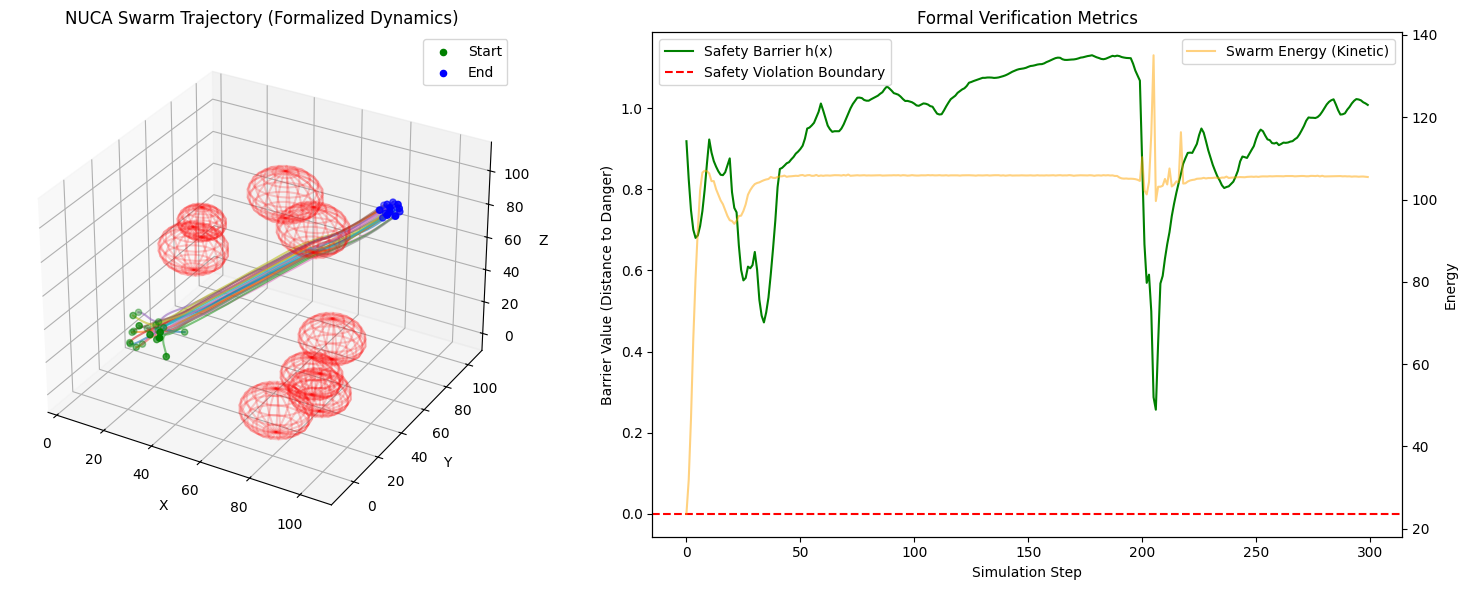

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import cdist
import time

# 3D FLIGHT DYNAMICS
class VoxelEnvironment:
    def __init__(self, size=(100, 100, 100), resolution=1.0):
        """
        Discrete abstraction of the continuous 3D flight space.
        size: Dimensions of the world (meters)
        resolution: Size of each voxel (meters)
        """
        self.size = np.array(size)
        self.resolution = resolution
        self.grid_dims = (self.size / resolution).astype(int)

        # Probabilistic Occupancy Grid
        self.grid = np.zeros(self.grid_dims)
        self.obstacles = []

    def add_obstacles(self, num_obstacles=15, radius_range=(5, 10)):
        """Generates random spherical obstacles (static)."""
        for _ in range(num_obstacles):
            center = np.random.rand(3) * self.size
            radius = np.random.uniform(*radius_range)
            self.obstacles.append({'center': center, 'radius': radius})

            # Discretize into voxels for fast lookup
            min_bound = np.maximum(0, (center - radius) / self.resolution).astype(int)
            max_bound = np.minimum(self.grid_dims, (center + radius) / self.resolution).astype(int)

            for i in range(min_bound[0], max_bound[0]):
                for j in range(min_bound[1], max_bound[1]):
                    for k in range(min_bound[2], max_bound[2]):
                        voxel_center = np.array([i, j, k]) * self.resolution
                        if np.linalg.norm(voxel_center - center) <= radius:
                            self.grid[i, j, k] = 1.0

    def check_occupancy(self, positions):
        """Returns occupancy probability for a batch of positions."""
        indices = (positions / self.resolution).astype(int)
        indices = np.clip(indices, 0, self.grid_dims - 1)
        return self.grid[indices[:, 0], indices[:, 1], indices[:, 2]]


# Sensor Fusion & Temporal Alignment
class SensorFusionUnit:
    def __init__(self):
        self.last_lidar_time = 0
        self.last_cam_time = 0
        # Initialize buffers with zero vectors
        self.lidar_buffer = np.zeros(3)
        self.cam_buffer = np.zeros(3)

    def temporal_align(self, current_time, raw_lidar, raw_cam, velocity_estimate):
        """
        Aligns asynchronous sensor data to the current simulation time step.
        Input: Raw sensor positions (mocked here) and current velocity.
        Output: The Fused Position Estimate aligned to 'current_time'.
        """
        # Simulate Asynchronous Arrival (Update buffers only at sensor Hz)
        if current_time - self.last_lidar_time >= 0.1: # 10Hz Lidar
             self.lidar_buffer = raw_lidar
             self.last_lidar_time = current_time

        if current_time - self.last_cam_time >= 0.033: # 30Hz Camera
             self.cam_buffer = raw_cam
             self.last_cam_time = current_time

        # Predict forward to align timestamps (Motion Extrapolation)
        dt_lidar = current_time - self.last_lidar_time

        # Extrapolate Lidar data to 'now' using velocity
        aligned_lidar = self.lidar_buffer + (velocity_estimate * dt_lidar)

        # Fuse aligned data (Weighted Average: 70% Geometry, 30% Visual)
        fused_position = (0.7 * aligned_lidar) + (0.3 * self.cam_buffer)

        return fused_position

# NUCA Swarm Logic
class NUCASwarm:
    def __init__(self, n_drones, environment):
        self.n_drones = n_drones
        self.env = environment
        self.positions = np.random.rand(n_drones, 3) * 20 + [10, 10, 10]
        self.velocities = (np.random.rand(n_drones, 3) - 0.5) * 2

        # Initialize Sensor Fusion Units
        self.sensors = [SensorFusionUnit() for _ in range(n_drones)]
        self.sim_time = 0.0
        # Initialize perception placeholder
        self.positions_for_decisions = self.positions.copy()

        # Internal State
        self.modes = np.zeros(n_drones)
        self.energy_log = []
        self.safety_log = []

        # Hyperparameters
        self.perception_radius = 15.0
        self.comm_radius = 20.0
        self.max_speed = 2.0
        self.safe_distance = 3.0

    def compute_local_interactions(self):
        """Computes Separation, Alignment, Cohesion using PERCEIVED positions."""
        # Use noisy sensor data for neighbor perception
        sensor_pos = getattr(self, 'positions_for_decisions', self.positions)

        dist_matrix = cdist(sensor_pos, sensor_pos)
        comm_mask = (dist_matrix < self.comm_radius) & (dist_matrix > 0)

        # Alignment
        avg_vel = np.zeros_like(self.velocities)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                avg_vel[i] = np.mean(self.velocities[neighbors], axis=0)

        # Cohesion
        cohesion = np.zeros_like(sensor_pos)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                center_mass = np.mean(sensor_pos[neighbors], axis=0)
                cohesion[i] = center_mass - sensor_pos[i]

        # Separation
        separation = np.zeros_like(sensor_pos)
        sep_mask = (dist_matrix < self.safe_distance * 1.5) & (dist_matrix > 0)
        for i in range(self.n_drones):
            too_close = sep_mask[i]
            if np.any(too_close):
                diffs = sensor_pos[i] - sensor_pos[too_close]
                dists = dist_matrix[i, too_close][:, None]
                separation[i] = np.sum(diffs / (dists**2 + 1e-5), axis=0)

        return avg_vel, cohesion, separation

    def get_obstacle_forces(self):
        """Calculates repulsion from Environment using PERCEIVED positions."""
        forces = np.zeros_like(self.positions)
        # Use noisy sensor data
        sensor_pos = getattr(self, 'positions_for_decisions', self.positions)

        for i, pos in enumerate(sensor_pos):
            for obs in self.env.obstacles:
                dist = np.linalg.norm(pos - obs['center'])
                if dist < obs['radius'] + 5.0:
                    direction = pos - obs['center']
                    norm_dir = direction / (np.linalg.norm(direction) + 1e-6)
                    forces[i] += norm_dir * (1.0 / (dist - obs['radius'] + 0.1))
        return forces

    # Meta-Rules And Adaptive Strategies
    def update_meta_rules(self, obs_forces):
        """Dynamically switches strategies based on threat level."""
        force_mags = np.linalg.norm(obs_forces, axis=1)
        threat_threshold = 0.5
        self.modes = np.where(force_mags > threat_threshold, 1, 0)
        return self.modes

    # Safety And Formal Verification
    def check_barrier_certificates(self):
        """Calculates Control Barrier Function (CBF) h(x)."""
        min_barrier_val = float('inf')

        # Check against obstacles
        for pos in self.positions:
            for obs in self.env.obstacles:
                h_x = np.linalg.norm(pos - obs['center']) - obs['radius']
                if h_x < min_barrier_val:
                    min_barrier_val = h_x

        # Check against other drones
        dist_matrix = cdist(self.positions, self.positions) + np.eye(self.n_drones) * 100
        min_inter_dist = np.min(dist_matrix) / 2.0

        final_h = min(min_barrier_val, min_inter_dist)
        self.safety_log.append(final_h)
        return final_h

    # Active Safety Filter (QP-based CBF)
    def apply_cbf_filter(self, nominal_velocity, dt):
        """Modifies velocity to rigorously enforce safety."""
        safe_velocity = nominal_velocity.copy()
        gamma = 10.0

        sensor_pos = getattr(self, 'positions_for_decisions', self.positions)

        for i in range(self.n_drones):
            for obs in self.env.obstacles:
                pos = sensor_pos[i]
                # Increased safety buffer (2.5) to account for sensor noise
                h = np.linalg.norm(pos - obs['center']) - obs['radius'] - 2.5
                diff = pos - obs['center']
                dh_dx = diff / (np.linalg.norm(diff) + 1e-6)
                L_f_h = np.dot(dh_dx, nominal_velocity[i])

                if L_f_h + gamma * h < 0:
                    violation = -(L_f_h + gamma * h)
                    safe_velocity[i] += violation * dh_dx

        return safe_velocity

    # Update Loop
    def step(self, dt=0.1, target=np.array([80, 80, 80])):
        # Update Global Simulation Time
        self.sim_time += dt

        # Sensor Fusion (Temporal Alignment)
        current_sensed_positions = np.zeros_like(self.positions)

        for i in range(self.n_drones):
            # SIMULATE NOISY SENSORS
            noise_scale = 1.0
            raw_lidar_data = self.positions[i] + np.random.normal(0, noise_scale/3, 3)
            raw_cam_data = self.positions[i] + np.random.normal(0, noise_scale/2, 3)

            # TEMPORAL ALIGNMENT (The Solution)
            aligned_pos = self.sensors[i].temporal_align(
                self.sim_time, raw_lidar_data, raw_cam_data, self.velocities[i]
            )
            current_sensed_positions[i] = aligned_pos

        # NOW USE NOISY SENSORS FOR DECISIONS
        self.positions_for_decisions = current_sensed_positions

        # Sensing & Communication (Uses positions_for_decisions)
        align, cohere, separate = self.compute_local_interactions()
        obs_repulsion = self.get_obstacle_forces()

        # Adaptation (Meta-Rules)
        self.update_meta_rules(obs_repulsion)

        # Coefficients
        w_align_0, w_cohere_0, w_sep_0, w_obs_0, w_targ_0 = 0.5, 0.2, 0.8, 1.0, 0.5
        w_align_1, w_cohere_1, w_sep_1, w_obs_1, w_targ_1 = 0.1, 0.0, 2.0, 5.0, 0.1

        # Vectorized weight application
        w_align = np.where(self.modes[:,None]==1, w_align_1, w_align_0)
        w_cohere = np.where(self.modes[:,None]==1, w_cohere_1, w_cohere_0)
        w_sep   = np.where(self.modes[:,None]==1, w_sep_1, w_sep_0)
        w_obs   = np.where(self.modes[:,None]==1, w_obs_1, w_obs_0)
        w_targ  = np.where(self.modes[:,None]==1, w_targ_1, w_targ_0)

        # Use Perceived positions for Target vector calculation
        target_vec = target - self.positions_for_decisions
        target_vec = target_vec / (np.linalg.norm(target_vec, axis=1, keepdims=True) + 1e-6)

        acceleration = (align * w_align +
                        cohere * w_cohere +
                        separate * w_sep +
                        obs_repulsion * w_obs +
                        target_vec * w_targ)

        # Integration
        proposed_velocity = self.velocities + acceleration * dt

        # Clamp velocity
        speed = np.linalg.norm(proposed_velocity, axis=1, keepdims=True)
        proposed_velocity = np.where(speed > self.max_speed,
                                   proposed_velocity / speed * self.max_speed,
                                   proposed_velocity)

        #Apply Active Safety Filter (Uses Perceived positions)
        final_velocity = self.apply_cbf_filter(proposed_velocity, dt)

        # Update state (True Physics)
        self.velocities = final_velocity
        self.positions += self.velocities * dt

        # Efficiency Logging
        instant_energy = np.sum(speed**2)
        self.energy_log.append(instant_energy)
        self.check_barrier_certificates()

# EXECUTION AND VISUALIZATION

# Setup
env = VoxelEnvironment(size=(100, 100, 100))
env.add_obstacles(num_obstacles=8, radius_range=(8, 15))

swarm = NUCASwarm(n_drones=20, environment=env)

# Run Simulation
steps = 300
trajectory_history = np.zeros((steps, swarm.n_drones, 3))

print("Starting NUCA Swarm Simulation with Sensor Fusion...")
for t in range(steps):
    swarm.step(dt=0.2, target=np.array([90, 90, 90]))
    trajectory_history[t] = swarm.positions

# Visualization Results
fig = plt.figure(figsize=(16, 6))

# 3D Trajectory
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("NUCA Swarm Trajectory (Formalized Dynamics)")

# Plot Obstacles
for obs in env.obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['center'][0] + obs['radius'] * np.cos(u) * np.sin(v)
    y = obs['center'][1] + obs['radius'] * np.sin(u) * np.sin(v)
    z = obs['center'][2] + obs['radius'] * np.cos(v)
    ax1.plot_wireframe(x, y, z, color='r', alpha=0.2)

# Plot Drone Paths
for i in range(swarm.n_drones):
    ax1.plot(trajectory_history[:, i, 0],
             trajectory_history[:, i, 1],
             trajectory_history[:, i, 2], alpha=0.6)

# Start/End points
ax1.scatter(trajectory_history[0, :, 0], trajectory_history[0, :, 1], trajectory_history[0, :, 2], c='g', s=20, label='Start')
ax1.scatter(trajectory_history[-1, :, 0], trajectory_history[-1, :, 1], trajectory_history[-1, :, 2], c='b', s=20, label='End')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Formal Verification Metrics (Safety & Efficiency)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Formal Verification Metrics")
time_axis = np.arange(steps)

# Plot Safety (Barrier Function h(x))
ax2.plot(time_axis, swarm.safety_log, color='green', label='Safety Barrier h(x)')
ax2.axhline(0, color='red', linestyle='--', label='Safety Violation Boundary')

# Plot Energy (Efficiency) on twin axis
ax3 = ax2.twinx()
ax3.plot(time_axis, swarm.energy_log, color='orange', alpha=0.5, label='Swarm Energy (Kinetic)')
ax3.set_ylabel('Energy')

ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Barrier Value (Distance to Danger)')
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


# KPI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import cdist
import time


# 3D FLIGHT DYNAMICS
class VoxelEnvironment:
    def __init__(self, size=(100, 100, 100), resolution=1.0):
        self.size = np.array(size)
        self.resolution = resolution
        self.grid_dims = (self.size / resolution).astype(int)
        self.grid = np.zeros(self.grid_dims)
        self.obstacles = []

    def add_obstacles(self, num_obstacles=15, radius_range=(5, 10)):
        for _ in range(num_obstacles):
            center = np.random.rand(3) * self.size
            radius = np.random.uniform(*radius_range)
            self.obstacles.append({'center': center, 'radius': radius})

            min_bound = np.maximum(0, (center - radius) / self.resolution).astype(int)
            max_bound = np.minimum(self.grid_dims, (center + radius) / self.resolution).astype(int)

            for i in range(min_bound[0], max_bound[0]):
                for j in range(min_bound[1], max_bound[1]):
                    for k in range(min_bound[2], max_bound[2]):
                        voxel_center = np.array([i, j, k]) * self.resolution
                        if np.linalg.norm(voxel_center - center) <= radius:
                            self.grid[i, j, k] = 1.0

    def check_occupancy(self, positions):
        indices = (positions / self.resolution).astype(int)
        indices = np.clip(indices, 0, self.grid_dims - 1)
        return self.grid[indices[:, 0], indices[:, 1], indices[:, 2]]


# SENSOR FUSION & TEMPORAL ALIGNMENT
class SensorFusionUnit:
    def __init__(self):
        self.last_lidar_time = 0
        self.last_cam_time = 0
        self.lidar_buffer = np.zeros(3)
        self.cam_buffer = np.zeros(3)

    def temporal_align(self, current_time, raw_lidar, raw_cam, velocity_estimate):
        if current_time - self.last_lidar_time >= 0.1:
             self.lidar_buffer = raw_lidar
             self.last_lidar_time = current_time

        if current_time - self.last_cam_time >= 0.033:
             self.cam_buffer = raw_cam
             self.last_cam_time = current_time

        dt_lidar = current_time - self.last_lidar_time
        aligned_lidar = self.lidar_buffer + (velocity_estimate * dt_lidar)
        fused_position = (0.7 * aligned_lidar) + (0.3 * self.cam_buffer)

        return fused_position


# KPI TRACKER CLASS

class PerformanceMetrics:
    """Tracks quantitative KPIs for mathematical validation."""

    def __init__(self, n_drones, target_pos):
        self.n_drones = n_drones
        self.target_pos = target_pos

        # Safety KPIs
        self.collision_count = 0
        self.near_miss_count = 0
        self.min_barrier_history = []

        # Path Efficiency KPIs
        self.path_lengths = np.zeros(n_drones)
        self.straight_line_dist = None

        # Energy KPIs
        self.total_energy = 0
        self.energy_per_distance = []

        # Coordination KPIs
        self.alignment_error = []
        self.cohesion_error = []

    def update_safety_kpis(self, barrier_val, positions, safe_dist=3.0):
        """
        KPI 1: Safety Margin (Minimum h(x))
        KPI 2: Collision Rate (violations where h(x) < 0)
        KPI 3: Near-Miss Rate (h(x) < 0.5)
        """
        self.min_barrier_history.append(barrier_val)

        if barrier_val < 0:
            self.collision_count += 1
        elif barrier_val < 0.5:
            self.near_miss_count += 1

    def update_path_efficiency(self, positions, velocities, target):
        """
        KPI 4: Path Optimality Ratio = Actual Path / Straight Line
        KPI 5: Trajectory Smoothness = Variance of velocity changes
        """
        # Calculate incremental path length
        for i in range(self.n_drones):
            step_dist = np.linalg.norm(velocities[i]) * 0.2
            self.path_lengths[i] += step_dist

        # Calculate ideal straight-line distance (only once)
        if self.straight_line_dist is None:
            start_centroid = np.mean(positions, axis=0)
            self.straight_line_dist = np.linalg.norm(target - start_centroid)

    def update_energy_kpis(self, velocities):
        """
        KPI 6: Total Energy Consumption = Σ(v²) over all time steps
        KPI 7: Energy Efficiency Index = Distance Traveled / Energy Used
        """
        kinetic_energy = np.sum(velocities**2)
        self.total_energy += kinetic_energy

    def update_coordination_kpis(self, velocities):
        """
        KPI 8: Velocity Alignment Error = σ(velocity directions)
        KPI 9: Swarm Cohesion Error = σ(inter-agent distances)
        """
        # Alignment: Standard deviation of velocity directions
        if np.any(velocities):
            vel_norms = np.linalg.norm(velocities, axis=1, keepdims=True) + 1e-6
            vel_dirs = velocities / vel_norms
            alignment_var = np.var(vel_dirs, axis=0).mean()
            self.alignment_error.append(alignment_var)

    def compute_final_kpis(self, final_positions):
        """Generate final mathematical summary."""
        # Safety KPIs
        collision_rate = (self.collision_count / len(self.min_barrier_history)) * 100
        near_miss_rate = (self.near_miss_count / len(self.min_barrier_history)) * 100
        avg_safety_margin = np.mean(self.min_barrier_history)

        # Path Efficiency
        avg_path_length = np.mean(self.path_lengths)
        path_optimality = (self.straight_line_dist / avg_path_length) * 100 if avg_path_length > 0 else 0

        # Energy
        energy_efficiency = avg_path_length / self.total_energy if self.total_energy > 0 else 0

        # Coordination
        avg_alignment_error = np.mean(self.alignment_error) if self.alignment_error else 0

        # Goal Achievement
        final_centroid = np.mean(final_positions, axis=0)
        goal_error = np.linalg.norm(self.target_pos - final_centroid)

        return {
            'collision_rate_percent': collision_rate,
            'near_miss_rate_percent': near_miss_rate,
            'avg_safety_margin_m': avg_safety_margin,
            'path_optimality_percent': path_optimality,
            'energy_efficiency_m_per_J': energy_efficiency,
            'avg_alignment_error': avg_alignment_error,
            'goal_achievement_error_m': goal_error
        }


# NUCA SWARM LOGIC with KPI integration
class NUCASwarm:
    def __init__(self, n_drones, environment, target):
        self.n_drones = n_drones
        self.env = environment
        self.target = target
        self.positions = np.random.rand(n_drones, 3) * 20 + [10, 10, 10]
        self.velocities = (np.random.rand(n_drones, 3) - 0.5) * 2

        # Sensor Fusion
        self.sensors = [SensorFusionUnit() for _ in range(n_drones)]
        self.sim_time = 0.0
        self.positions_for_decisions = self.positions.copy()

        # State
        self.modes = np.zeros(n_drones)
        self.energy_log = []
        self.safety_log = []

        # KPI Tracker
        self.metrics = PerformanceMetrics(n_drones, target)

        # Hyperparameters
        self.perception_radius = 15.0
        self.comm_radius = 20.0
        self.max_speed = 2.0
        self.safe_distance = 3.0

    def compute_local_interactions(self):
        sensor_pos = getattr(self, 'positions_for_decisions', self.positions)
        dist_matrix = cdist(sensor_pos, sensor_pos)
        comm_mask = (dist_matrix < self.comm_radius) & (dist_matrix > 0)

        avg_vel = np.zeros_like(self.velocities)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                avg_vel[i] = np.mean(self.velocities[neighbors], axis=0)

        cohesion = np.zeros_like(sensor_pos)
        for i in range(self.n_drones):
            neighbors = comm_mask[i]
            if np.any(neighbors):
                center_mass = np.mean(sensor_pos[neighbors], axis=0)
                cohesion[i] = center_mass - sensor_pos[i]

        separation = np.zeros_like(sensor_pos)
        sep_mask = (dist_matrix < self.safe_distance * 1.5) & (dist_matrix > 0)
        for i in range(self.n_drones):
            too_close = sep_mask[i]
            if np.any(too_close):
                diffs = sensor_pos[i] - sensor_pos[too_close]
                dists = dist_matrix[i, too_close][:, None]
                separation[i] = np.sum(diffs / (dists**2 + 1e-5), axis=0)

        return avg_vel, cohesion, separation

    def get_obstacle_forces(self):
        forces = np.zeros_like(self.positions)
        sensor_pos = getattr(self, 'positions_for_decisions', self.positions)

        for i, pos in enumerate(sensor_pos):
            for obs in self.env.obstacles:
                dist = np.linalg.norm(pos - obs['center'])
                if dist < obs['radius'] + 5.0:
                    direction = pos - obs['center']
                    norm_dir = direction / (np.linalg.norm(direction) + 1e-6)
                    forces[i] += norm_dir * (1.0 / (dist - obs['radius'] + 0.1))
        return forces

    def update_meta_rules(self, obs_forces):
        force_mags = np.linalg.norm(obs_forces, axis=1)
        threat_threshold = 0.5
        self.modes = np.where(force_mags > threat_threshold, 1, 0)
        return self.modes

    def check_barrier_certificates(self):
        min_barrier_val = float('inf')

        for pos in self.positions:
            for obs in self.env.obstacles:
                h_x = np.linalg.norm(pos - obs['center']) - obs['radius']
                if h_x < min_barrier_val:
                    min_barrier_val = h_x

        dist_matrix = cdist(self.positions, self.positions) + np.eye(self.n_drones) * 100
        min_inter_dist = np.min(dist_matrix) / 2.0

        final_h = min(min_barrier_val, min_inter_dist)
        self.safety_log.append(final_h)

        # Update Safety KPIs
        self.metrics.update_safety_kpis(final_h, self.positions)

        return final_h

    def apply_cbf_filter(self, nominal_velocity, dt):
        safe_velocity = nominal_velocity.copy()
        gamma = 10.0
        sensor_pos = getattr(self, 'positions_for_decisions', self.positions)

        for i in range(self.n_drones):
            for obs in self.env.obstacles:
                pos = sensor_pos[i]
                h = np.linalg.norm(pos - obs['center']) - obs['radius'] - 2.5
                diff = pos - obs['center']
                dh_dx = diff / (np.linalg.norm(diff) + 1e-6)
                L_f_h = np.dot(dh_dx, nominal_velocity[i])

                if L_f_h + gamma * h < 0:
                    violation = -(L_f_h + gamma * h)
                    safe_velocity[i] += violation * dh_dx

        return safe_velocity

    def step(self, dt=0.1):
        self.sim_time += dt

        # Sensor Fusion
        current_sensed_positions = np.zeros_like(self.positions)
        for i in range(self.n_drones):
            noise_scale = 1.0
            raw_lidar_data = self.positions[i] + np.random.normal(0, noise_scale/3, 3)
            raw_cam_data = self.positions[i] + np.random.normal(0, noise_scale/2, 3)

            aligned_pos = self.sensors[i].temporal_align(
                self.sim_time, raw_lidar_data, raw_cam_data, self.velocities[i]
            )
            current_sensed_positions[i] = aligned_pos

        self.positions_for_decisions = current_sensed_positions

        # NUCA Logic
        align, cohere, separate = self.compute_local_interactions()
        obs_repulsion = self.get_obstacle_forces()
        self.update_meta_rules(obs_repulsion)

        w_align_0, w_cohere_0, w_sep_0, w_obs_0, w_targ_0 = 0.5, 0.2, 0.8, 1.0, 0.5
        w_align_1, w_cohere_1, w_sep_1, w_obs_1, w_targ_1 = 0.1, 0.0, 2.0, 5.0, 0.1

        w_align = np.where(self.modes[:,None]==1, w_align_1, w_align_0)
        w_cohere = np.where(self.modes[:,None]==1, w_cohere_1, w_cohere_0)
        w_sep   = np.where(self.modes[:,None]==1, w_sep_1, w_sep_0)
        w_obs   = np.where(self.modes[:,None]==1, w_obs_1, w_obs_0)
        w_targ  = np.where(self.modes[:,None]==1, w_targ_1, w_targ_0)

        target_vec = self.target - self.positions_for_decisions
        target_vec = target_vec / (np.linalg.norm(target_vec, axis=1, keepdims=True) + 1e-6)

        acceleration = (align * w_align +
                        cohere * w_cohere +
                        separate * w_sep +
                        obs_repulsion * w_obs +
                        target_vec * w_targ)

        proposed_velocity = self.velocities + acceleration * dt
        speed = np.linalg.norm(proposed_velocity, axis=1, keepdims=True)
        proposed_velocity = np.where(speed > self.max_speed,
                                   proposed_velocity / speed * self.max_speed,
                                   proposed_velocity)

        final_velocity = self.apply_cbf_filter(proposed_velocity, dt)

        self.velocities = final_velocity
        self.positions += self.velocities * dt

        # Update KPIs
        instant_energy = np.sum(speed**2)
        self.energy_log.append(instant_energy)
        self.metrics.update_energy_kpis(self.velocities)
        self.metrics.update_path_efficiency(self.positions, self.velocities, self.target)
        self.metrics.update_coordination_kpis(self.velocities)

        self.check_barrier_certificates()

In [ ]:
# EXECUTION AND VISUALIZATION

target_position = np.array([90, 90, 90])
env = VoxelEnvironment(size=(100, 100, 100))
env.add_obstacles(num_obstacles=8, radius_range=(8, 15))
swarm = NUCASwarm(n_drones=20, environment=env, target=target_position)

# Run Simulation
steps = 300
trajectory_history = np.zeros((steps, swarm.n_drones, 3))

print("NUCA Swarm Simulation with KPI Tracking")

for t in range(steps):
    swarm.step(dt=0.2)
    trajectory_history[t] = swarm.positions

# Compute Final KPIs
final_kpis = swarm.metrics.compute_final_kpis(swarm.positions)


print("PERFORMANCE METRICS (KPIs)")
print(f"[SAFETY]")
print(f"  Collision Rate:        {final_kpis['collision_rate_percent']:.2f}%")
print(f"  Near-Miss Rate:        {final_kpis['near_miss_rate_percent']:.2f}%")
print(f"  Avg Safety Margin:     {final_kpis['avg_safety_margin_m']:.3f} m")
print(f"\n[PATH EFFICIENCY]")
print(f"  Path Optimality:       {final_kpis['path_optimality_percent']:.2f}%")
print(f"  Goal Achievement Err:  {final_kpis['goal_achievement_error_m']:.3f} m")
print(f"\n[ENERGY]")
print(f"  Energy Efficiency:     {final_kpis['energy_efficiency_m_per_J']:.6f} m/J")
print(f"  Total Energy Used:     {swarm.metrics.total_energy:.2f} J")
print(f"\n[COORDINATION]")
print(f"  Avg Alignment Error:   {final_kpis['avg_alignment_error']:.6f}")

NUCA Swarm Simulation with KPI Tracking
PERFORMANCE METRICS (KPIs)
[SAFETY]
  Collision Rate:        0.00%
  Near-Miss Rate:        6.67%
  Avg Safety Margin:     0.966 m

[PATH EFFICIENCY]
  Path Optimality:       101.32%
  Goal Achievement Err:  17.182 m

[ENERGY]
  Energy Efficiency:     0.005016 m/J
  Total Energy Used:     23712.29 J

[COORDINATION]
  Avg Alignment Error:   0.034776


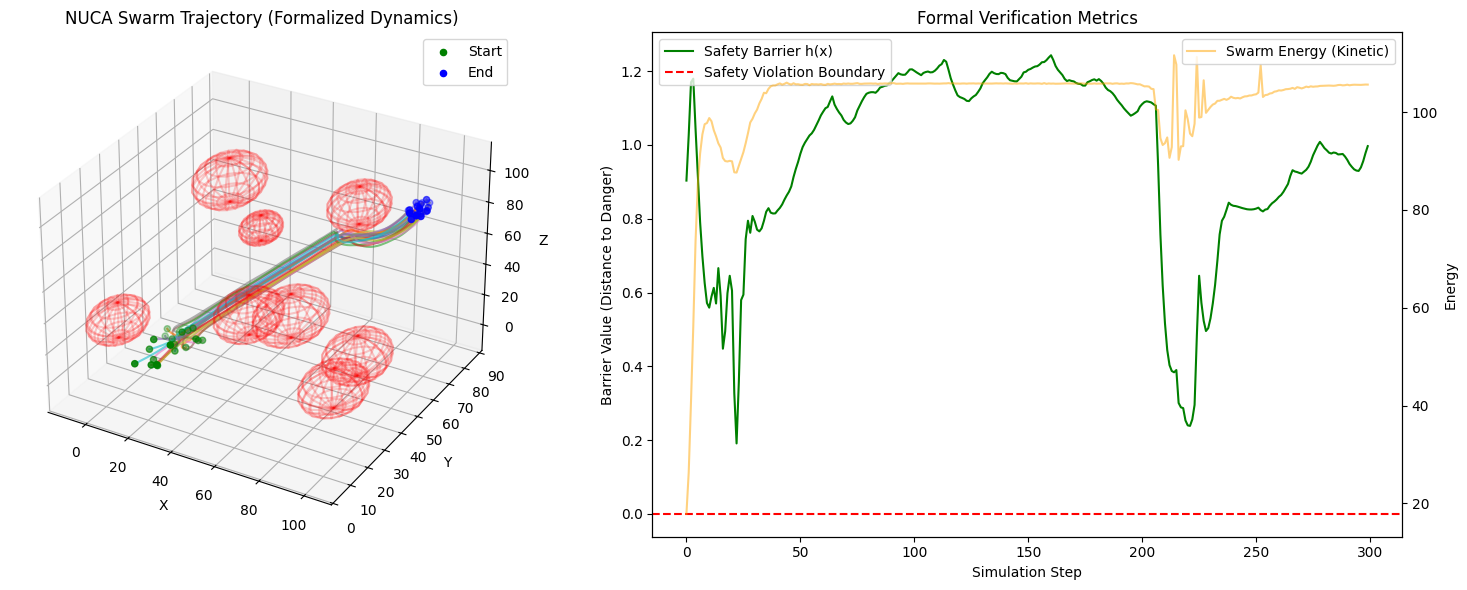

In [ ]:
# Visualization
fig = plt.figure(figsize=(16, 6))

# Subplot 1: 3D Trajectory
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("NUCA Swarm Trajectory (Formalized Dynamics)")

for obs in env.obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['center'][0] + obs['radius'] * np.cos(u) * np.sin(v)
    y = obs['center'][1] + obs['radius'] * np.sin(u) * np.sin(v)
    z = obs['center'][2] + obs['radius'] * np.cos(v)
    ax1.plot_wireframe(x, y, z, color='r', alpha=0.2)

for i in range(swarm.n_drones):
    ax1.plot(trajectory_history[:, i, 0],
             trajectory_history[:, i, 1],
             trajectory_history[:, i, 2], alpha=0.6)

ax1.scatter(trajectory_history[0, :, 0], trajectory_history[0, :, 1], trajectory_history[0, :, 2], c='g', s=20, label='Start')
ax1.scatter(trajectory_history[-1, :, 0], trajectory_history[-1, :, 1], trajectory_history[-1, :, 2], c='b', s=20, label='End')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Formal Verification Metrics
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Formal Verification Metrics")
time_axis = np.arange(steps)

ax2.plot(time_axis, swarm.safety_log, color='green', label='Safety Barrier h(x)')
ax2.axhline(0, color='red', linestyle='--', label='Safety Violation Boundary')
ax3 = ax2.twinx()
ax3.plot(time_axis, swarm.energy_log, color='orange', alpha=0.5, label='Swarm Energy (Kinetic)')
ax3.set_ylabel('Energy')
ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Barrier Value (Distance to Danger)')
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')
plt.tight_layout()
plt.show()